In [2]:
!pip3 install -U ucimlrepo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap

from sklearn.ensemble import IsolationForest
from ucimlrepo import fetch_ucirepo

In [4]:
power_consumption = fetch_ucirepo(id=235)

print(power_consumption.variables)


Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.


                    name     role         type demographic description units  \
0                   Date  Feature         Date        None        None  None   
1                   Time  Feature  Categorical        None        None  None   
2    Global_active_power  Feature   Continuous        None        None  None   
3  Global_reactive_power  Feature   Continuous        None        None  None   
4                Voltage  Feature   Continuous        None        None  None   
5       Global_intensity  Feature   Continuous        None        None  None   
6         Sub_metering_1  Feature   Continuous        None        None  None   
7         Sub_metering_2  Feature   Continuous        None        None  None   
8         Sub_metering_3  Feature   Continuous        None        None  None   

  missing_values  
0             no  
1             no  
2             no  
3             no  
4             no  
5             no  
6             no  
7             no  
8             no  


In [5]:
data = power_consumption.data.features
data["Date"] = pd.to_datetime(data["Date"], format="%d/%m/%Y")

# List of features to check
feature_columns = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3",
]

# Convert feature columns to numeric and replace any errors with NaN
data[feature_columns] = data[feature_columns].apply(pd.to_numeric, errors="coerce")

# Drop rows where all feature columns are missing (NaN)
data_cleaned = data.dropna(subset=feature_columns, how="all")

# Drop rows where ALL feature columns are NaN
data_cleaned.head()

# Now, this is not always the best practice when doing anomaly detection. Rows with a lot of missing values might indicate that an instance is an anomaly. In this case, we’re going to keep things simple — just keep that in mind when you’re applying Isolation Forest to your problem.


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
data_aggregated = data_cleaned.groupby("Date")[feature_columns].agg(["mean", "std"])

# Rename columns to the desired format (MEAN_ColumnName, STD_ColumnName)
data_aggregated.columns = [f"{agg_type.upper()}_{col}" for col, agg_type in data_aggregated.columns]

# Reset the index
data_aggregated.reset_index(inplace=True)

# Display the result
print(data_aggregated.shape)
data_aggregated.head()


(1433, 15)


,Date,MEAN_Global_active_power,STD_Global_active_power,MEAN_Global_reactive_power,STD_Global_reactive_power,MEAN_Voltage,STD_Voltage,MEAN_Global_intensity,STD_Global_intensity,MEAN_Sub_metering_1,STD_Sub_metering_1,MEAN_Sub_metering_2,STD_Sub_metering_2,MEAN_Sub_metering_3,STD_Sub_metering_3
0,2006-12-16,3.053475,1.026338,0.088187,0.099014,236.243763,2.922896,13.082828,4.283262,0.000000,0.000000,1.378788,5.158545,12.439394,7.455105
1,2006-12-17,2.354486,1.205795,0.156949,0.114873,240.087028,4.051467,9.999028,5.031445,1.411806,6.813244,2.907639,8.800654,9.264583,8.645364
2,2006-12-18,1.530435,1.005074,0.112356,0.109154,241.231694,3.719576,6.421667,4.248511,0.738194,4.999534,1.820139,6.746395,9.734722,8.765125
3,2006-12-19,1.157079,1.237602,0.104821,0.101591,241.999313,3.069492,4.926389,5.238010,0.582639,4.459545,5.279167,12.771085,4.303472,7.529344
4,2006-12-20,1.545658,1.320968,0.111804,0.094926,242.308062,3.345704,6.467361,5.556587,0.000000,0.000000,1.838889,7.084353,9.765972,8.799051


In [7]:
n_estimators = 100      # Number of trees
sample_size = 256       # Number of samples used to train each tree
contamination = 0.02    # Expected proportion of anomalies

In [8]:
features = data_aggregated.drop("Date", axis=1)

# Train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=n_estimators, contamination=contamination, max_samples=sample_size, random_state=42
)

iso_forest.fit(features)


X does not have valid feature names, but IsolationForest was fitted with feature names


IsolationForest(contamination=0.02, max_samples=256, random_state=42)

In [9]:
data_aggregated["anomaly_score"] = iso_forest.decision_function(features)
data_aggregated["anomaly"] = iso_forest.predict(features)

data_aggregated["anomaly"].value_counts()


 1    1404
-1      29
Name: anomaly, dtype: int64

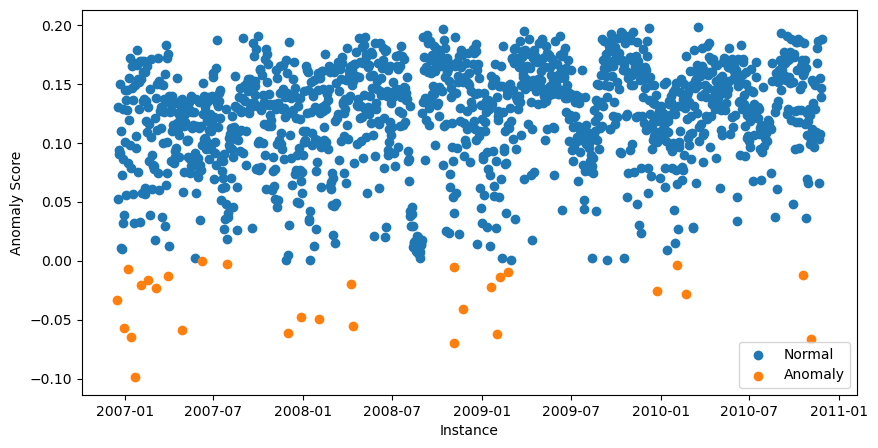

In [10]:
plt.figure(figsize=(10, 5))

# Plot normal instances
normal = data_aggregated[data_aggregated["anomaly"] == 1]
plt.scatter(normal["Date"], normal["anomaly_score"], label="Normal")

# Plot anomalies
anomalies = data_aggregated[data_aggregated["anomaly"] == -1]
plt.scatter(anomalies["Date"], anomalies["anomaly_score"], label="Anomaly")

plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()


In [13]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MEAN_Global_active_power    1433 non-null   float64
 1   STD_Global_active_power     1433 non-null   float64
 2   MEAN_Global_reactive_power  1433 non-null   float64
 3   STD_Global_reactive_power   1433 non-null   float64
 4   MEAN_Voltage                1433 non-null   float64
 5   STD_Voltage                 1433 non-null   float64
 6   MEAN_Global_intensity       1433 non-null   float64
 7   STD_Global_intensity        1433 non-null   float64
 8   MEAN_Sub_metering_1         1433 non-null   float64
 9   STD_Sub_metering_1          1433 non-null   float64
 10  MEAN_Sub_metering_2         1433 non-null   float64
 11  STD_Sub_metering_2          1433 non-null   float64
 12  MEAN_Sub_metering_3         1433 non-null   float64
 13  STD_Sub_metering_3          1433 

In [14]:
normal_sample = np.random.choice(normal.index, size=100, replace=False)
sample = np.append(anomalies.index, normal_sample)

len(sample)  # 129


129

In [18]:
np.bool = np.bool_
np.int = np.int32
np.float = np.float64

In [19]:
explainer = shap.Explainer(iso_forest.decision_function, features)
shap_values = explainer(features.iloc[sample])

Permutation explainer: 130it [05:21,  2.53s/it]                         


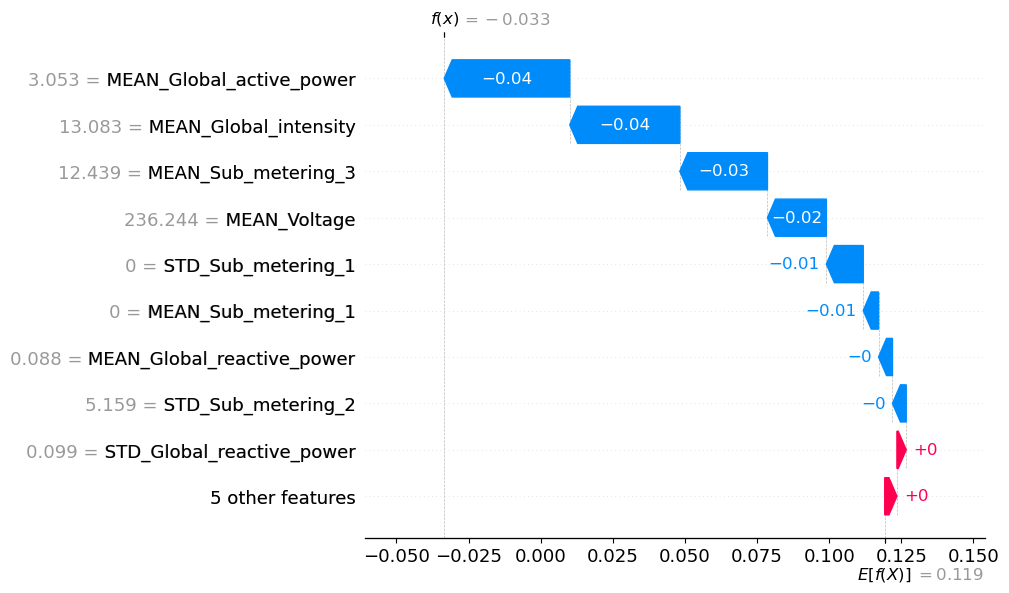

In [20]:
shap.plots.waterfall(shap_values[0])

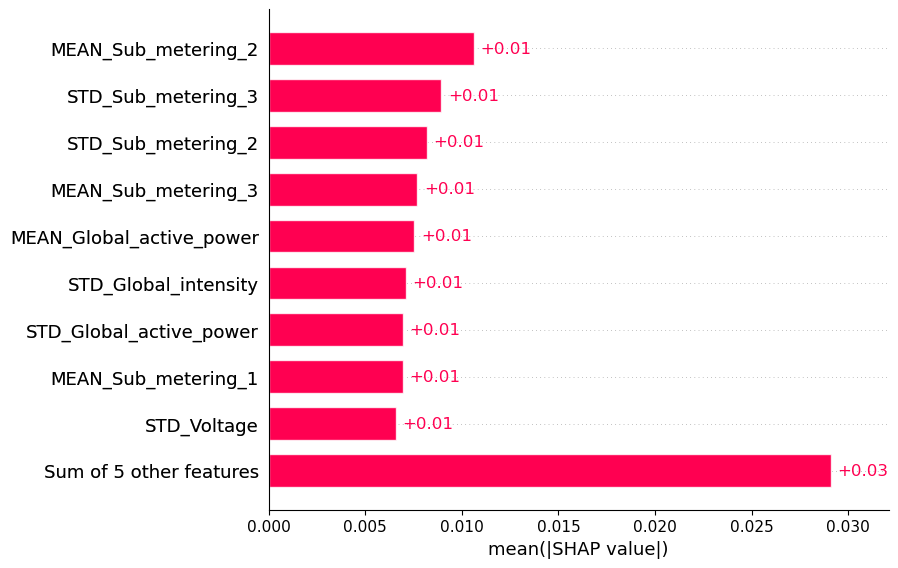

In [21]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


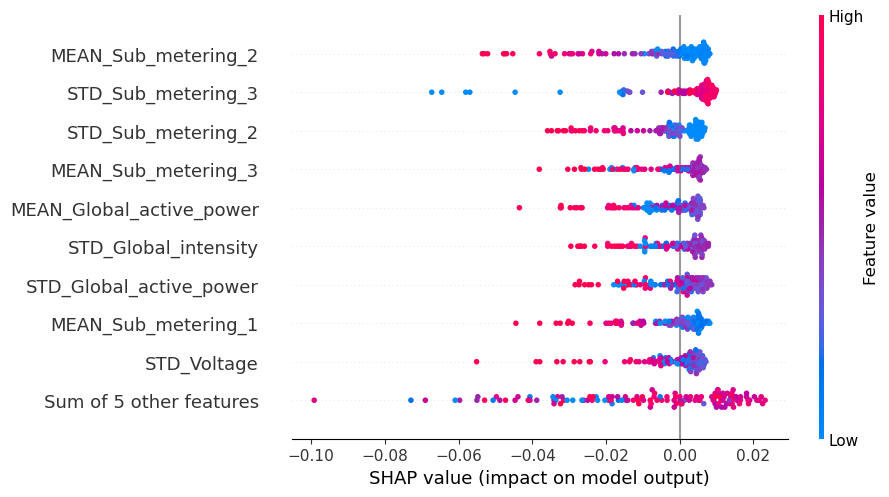

In [22]:
shap.plots.beeswarm(shap_values)

When interpreting this plot remember that anomaly scores less than zero indicate that the instance is an anomaly. So, when the SHAP value is less than zero, it tells us that the feature has contributed to this negative anomaly score. Looking at the first feature, we can see that when feature values are high the SHAP values are negative. In other words, anomalies tend to have higher readings for Sub_metering_2.

### TreeSHAP with Average Path Length

In [23]:
explainer = shap.TreeExplainer(iso_forest)
shap_values = explainer(features)

In [24]:
shap.plots.waterfall(shap_values[0])

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).